# How to Build a Dynamic City Dashboard: Automating Data Gathering from Dallas Open Data and ArcGIS API Integration

## Introduction

In an era where data-driven decision-making reigns supreme, the ability to access, analyze, and visualize data in real-time is paramount. City governments, organizations, and individuals alike are increasingly turning to data dashboards to monitor trends, track progress, and inform their actions. One prominent example of this is the daily updated dashboard developed by Johns Hopkins University to track the global COVID-19 pandemic.

This project has been divided into two tutorials. In this tutorial, we will focus on mastering the process of effortlessly collecting and updating police incident data from the API provided by the City of Dallas using Python. The next tutorial, written by my colleague Yanan Wu, will delve into leveraging this data to update a dashboard using ArcGIS Python API provided by ESRI.

By following this tutorial, you'll gain the skills and knowledge needed to seamlessly integrate Python into your workflow, automate data collection, and keep your datasets up-to-date with minimal effort. Stay tuned for the [next tutorial](https://ywu120766.medium.com/publish-a-web-map-on-arcgis-online-using-arcgis-api-for-python-a7b3dc639ed7), where you'll learn how to visualize this data effectively and create [dynamic dashboards](https://www.arcgis.com/apps/dashboards/009d082a54e74019a1568b634869d773) to showcase your insights. Let's dive in!

* [Police Incidents Data Card](https://www.dallasopendata.com/Public-Safety/Police-Incidents/qv6i-rri7/about_data)
* [Final Dashboard](https://www.arcgis.com/apps/dashboards/009d082a54e74019a1568b634869d773)

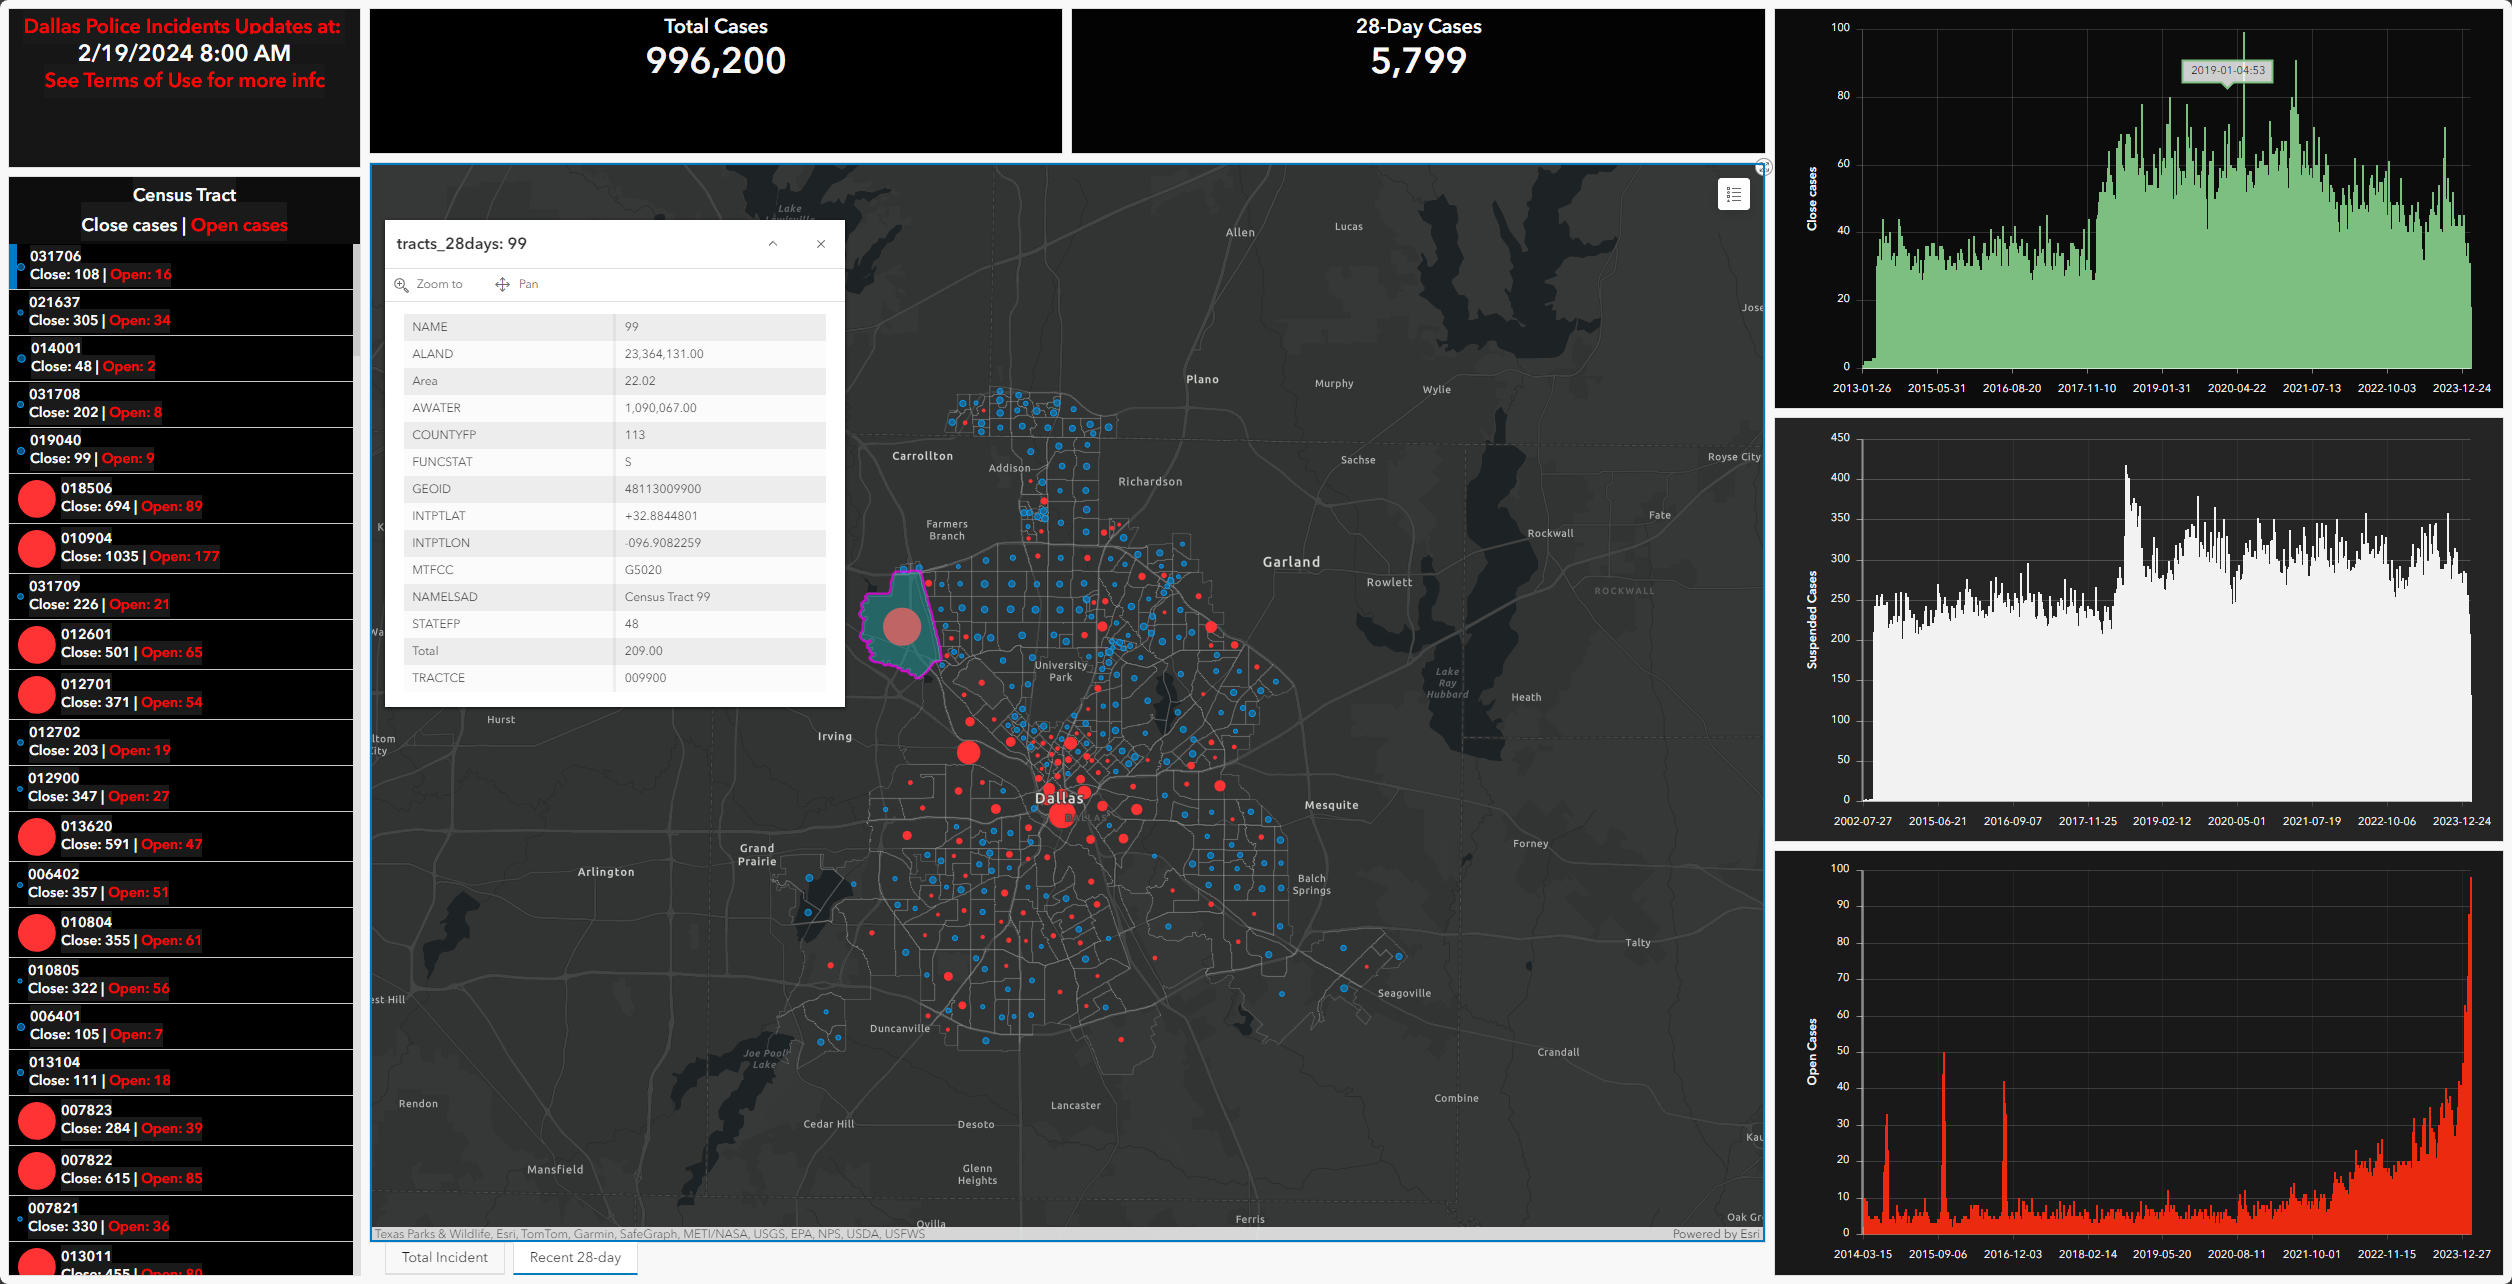

## Data acquiring
Load Libraries

In [1]:
import requests,json,os,datetime,zipfile
import geopandas as gpd
import pandas as pd
from datetime import datetime, timedelta

In [2]:
def zip_folder(folder_path, zip_path):
    """
    Compresses a folder into a ZIP file.

    Parameters:
        folder_path (str): Path to the folder to be zipped.
        zip_path (str): Path where the ZIP file will be saved.

    Returns:
        None
    """
    # Create a ZIP file object in write mode with ZIP_DEFLATED compression
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        # Iterate over all files and subdirectories in the specified folder
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                # Construct the full path to the current file
                file_path = os.path.join(root, file)
                # Write the current file to the ZIP file, preserving the directory structure
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Get today's date
today = datetime.now()
today_date = today.date()
today_date

datetime.date(2024, 2, 21)

In [3]:
## Keep want colname less 10 char 

column_mapping = {
    "incidentnum": "inct_id",
    "servnumid": "servnum",
    "reporteddate": "rep_date",
    "status": "status",
    "ucr_disp": "ucr",
    "x_coordinate": "x_coord",
    "y_cordinate": "y_coord",
    "zip_code": "zip_code",
    "date": "date",
    "geocoded_column": "geo_col"
}

### Get Police Incidents data

In [4]:
JSON_URL = 'https://www.dallasopendata.com/resource/qv6i-rri7.json'
content = requests.get(JSON_URL).text
dallas_incidents = json.loads(content)
df = pd.DataFrame(dallas_incidents)
df.head()

,incidentnum,servyr,servnumid,watch,signal,offincident,premise,objattack,incident_address,ra,...,gang,ucr_offense,ucr_offdesc,ucrcode,type,ro2badge,ro2name,apt,hate,splrpt
0,203058-2022,2022,203058-2022-01,1,PSE/09 - THEFT,THEFT OF PROP (AUTO ACC) <$100 - (NOT EMP),Apartment Parking Lot,Motor Vehicle,7152 FAIR OAKS AVE,4527,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,264509-2016,2016,264509-2016-01,2,58 - ROUTINE INVESTIGATION,FALSE STATEMENT FOR PROPERTY/CREDIT $2500 < $30K,Single Family Residence - Occupied,N/A,8545 MIDPARK RD,1022,...,No,FRAUD,FRAUD,1100,PART2,NaN,NaN,NaN,NaN,NaN
2,004110-2015,2015,004110-2015-01,2,58 - ROUTINE INVESTIGATION,CREDIT CARD OR DEBIT CARD ABUSE,Business Office,N/A,1400 S LAMAR ST,2123,...,No,FRAUD,FRAUD,1100,PART2,NaN,NaN,NaN,NaN,NaN
3,022647-2023,2023,022647-2023-01,1,58 - ROUTINE INVESTIGATION,ABANDONED PROPERTY (NO OFFENSE),Outdoor Area Public/Private,N/A,5509 DRANE DR,3087,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,195028-2021,2021,195028-2021-01,2,09V - UUMV,THEFT OF PROP > OR EQUAL $100 <$750 (NOT SHOPL...,"Highway, Street, Alley ETC",N/A,5204 ELKRIDGE DR,1216,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Cleaning

In [5]:
def preprocess_data(df):
    """
    Preprocesses the input DataFrame containing crime data.

    Parameters:
        df (DataFrame): Input DataFrame containing crime data.

    Returns:
        DataFrame: Preprocessed DataFrame with selected columns and standardized status values.
    """
    # Convert 'reporteddate' column to datetime format
    df['reporteddate'] = pd.to_datetime(df['reporteddate'])
    
    # Select desired columns
    want_col = ["incidentnum", "servnumid", 'reporteddate', 'status', "ucr_disp", "x_coordinate", "y_cordinate", "zip_code", "geocoded_column"]
    part_df = df[want_col].copy()  # Make a copy to avoid SettingWithCopyWarning
    
    # Standardize 'status' column values
    part_df.loc[:, 'status'] = part_df['status'].replace({
        'Suspended': 'Suspended', 
        'Clear by Arrest': 'Close', 
        'Closed/Cleared': 'Close', 
        'Clear by Exceptional Arrest': 'Close', 
        'Open': 'Open', 
        'Returned for Correction': 'None',
        'L': 'None'
    })
    
    # Convert 'reporteddate' column to datetime format
    part_df.loc[:, 'reporteddate'] = pd.to_datetime(part_df['reporteddate'])
    
    # Create a new 'date' column formatted as 'YYYY-MM-DD'
    part_df.loc[:, 'date'] = part_df['reporteddate'].dt.strftime("%Y-%m-%d")
    
    return part_df

processed_df = preprocess_data(df)

# Rename the columns using the column_mapping dictionary
processed_df.rename(columns=column_mapping, inplace=True)
processed_df.drop_duplicates(subset=['inct_id'],inplace=True)  ## Remove redundant records
processed_df.head()

,inct_id,servnum,rep_date,status,ucr,x_coord,y_coord,zip_code,geo_col,date
0,203058-2022,203058-2022-01,2022-11-09 07:03:00,Suspended,Suspended,2503598.1126,7005279.01372,75231,"{'latitude': '32.87309', 'longitude': '-96.757...",2022-11-09
1,264509-2016,264509-2016-01,2016-11-08 14:00:00,Suspended,Suspended,2503120.01184586,7028108.5845336,75240,"{'latitude': '32.93652', 'longitude': '-96.757...",2016-11-08
2,004110-2015,004110-2015-01,2015-01-08 12:00:00,Suspended,Suspended,2492641.4685,6966516.79958,75215,"{'latitude': '32.76737', 'longitude': '-96.795...",2015-01-08
3,022647-2023,022647-2023-01,2023-02-09 02:30:00,Suspended,Suspended,2485559.93145,6993803.018,75209,"{'latitude': '32.84277', 'longitude': '-96.816...",2023-02-09
4,195028-2021,195028-2021-01,2021-10-26 14:08:00,Suspended,Suspended,2519582.54979,6974453.76304,75227,"{'latitude': '32.78849', 'longitude': '-96.706...",2021-10-26


### Compare with existing data, updates new

In [6]:
# Get yesterday's date
yesterday = datetime.now() - timedelta(days=1)
yesterday_date = yesterday.date().__str__().replace('-', '_')
# Define the desired columns
wanted_columns = list(column_mapping.values())

# Check if the file exists before attempting to read it
file_path = os.path.join('.\\update_Data', f'{yesterday_date}_Totals.csv')
if os.path.exists(file_path):
    # Read existing data
    exist_data = pd.read_csv(file_path)
    
    # Filter out rows that already exist in the existing data
    save_index = ~processed_df['inct_id'].isin(exist_data['inct_id'])
    df_newData = processed_df[save_index]
    df_complete = pd.concat([df_newData,exist_data[wanted_columns]], ignore_index=True)    
    # Get today's date
    today = datetime.now().date().__str__().replace('-', '_')
else:
    df_complete = processed_df
    # print("Error: Yesterday's data file not found.")
    
non_geo_index = ~df_complete['x_coord'].isna() ## Remove without location information
df_complete = df_complete[non_geo_index]
print("Shape of the complete DataFrame:", df_complete.shape)

Shape of the complete DataFrame: (961, 10)


### Updates database

In [7]:
### Save as zip file

# Create a GeoDataFrame from DataFrame with x and y coordinates
gdf = gpd.GeoDataFrame(df_complete, 
                        geometry=gpd.points_from_xy(df_complete.x_coord,
                                                    df_complete.y_coord,
                                                    crs='EPSG:2276'))

# Convert 'reporteddate' to string format if it's not already
if gdf.dtypes['rep_date'] != 'object':
    gdf['rep_date'] = gdf['rep_date'].dt.strftime("%Y-%m-%d %H-%M-%S")

# Export GeoDataFrame into a folder
gdf.to_file('./Data/inct_Totals')
zip_folder('./Data/inct_Totals', './Data/inct_Totals.zip')

In [8]:
df_complete.describe()

,rep_date
count,961
mean,2020-07-26 15:34:19.764828160
min,2014-02-07 21:53:00
25%,2017-01-31 10:25:00
50%,2022-11-01 11:06:00
75%,2023-02-07 11:28:30
max,2024-01-03 17:21:49


In [9]:
### Save Recent 28-days file

# Convert 'reporteddate' to datetime format with error handling for coercion
df_complete.loc[:, 'rep_date'] = pd.to_datetime(df_complete['rep_date'], errors='coerce')

# Calculate 28 days before the latest date
day_before_28 = today.date() - timedelta(days=28)

# Filter data for the last 28 days
latest_28 =  df_complete[df_complete['rep_date'] > pd.Timestamp(day_before_28)]
print('Recent 28 days:', len(latest_28))

# Create GeoDataFrame for the last 28 days
recent_28 = gpd.GeoDataFrame(latest_28, geometry=gpd.points_from_xy(latest_28.x_coord,
                                                                    latest_28.y_coord,
                                                                    crs='EPSG:2276'))
# Convert 'reporteddate' to string format
recent_28['rep_date'] = recent_28['rep_date'].dt.strftime("%Y-%m-%d %H-%M-%S")

if (recent_28.shape[0] > 0):
    # Export GeoDataFrame into a folder
    recent_28.to_file('./Data/inct_28days')
    zip_folder('./Data/inct_28days', './Data/inct_28days.zip')

Recent 28 days: 0


## Aggregate points to census tracts

In [10]:
inct_total_gdf = gpd.read_file('./DATA/inct_Totals/inct_Totals.shp')
inct_total_gdf.status.value_counts()

status
Suspended    847
Close         87
Open          25
Name: count, dtype: int64

In [11]:
census_tract_gdf = gpd.read_file('./Data/census_tract/Dallas_Tracts.shp')
census_tract_gdf = census_tract_gdf.to_crs(inct_total_gdf.crs)

# Perform spatial overlay to find incident points within census tracts
polygon_within = gpd.overlay(inct_total_gdf, census_tract_gdf, how='intersection')
# Group by GEOID and count the number of points within each polygon
pts_within = polygon_within.groupby('GEOID').size().rename('points_within')

# Group by GEOID and status, then count the occurrences of each status within each polygon
status_counts = polygon_within.groupby(['GEOID', 'status']).size().unstack(fill_value=0)
# status_counts['GEOID'] = status_counts.index

print(status_counts.head())

status       Close  Open  Suspended
GEOID                              
48085031704      0     0          1
48085031706      0     0          1
48085031708      0     0          2
48085031709      1     0          3
48085031711      0     0          1


## Save to a zip file

In [12]:
census_tract_cts_gdf = census_tract_gdf.merge(pts_within, left_on = 'GEOID', right_index = True)
census_tract_cts_gdf.rename(columns = {'points_within': 'Total'}, inplace = True)
census_tract_cts_gdf.to_file('./Data/tracts_total', driver = 'ESRI Shapefile')
zip_folder('./Data/tracts_total', './Data/tracts_total.zip')

Congratulations! You've mastered the art of using Python to effortlessly collect and update police incident data from the API provided by the City of Dallas. Now, it's time to take your skills to the next level by leveraging this data to update a dashboard using ArcGIS Python API provided by ESRI.

For a comprehensive guide on how to achieve this, I recommend diving into the tutorial written by my colleague, Yanan Wu. Click on the link below to access the tutorial:
* [Tutorial: Integrating Python with ArcGIS for Dashboard Updates](https://ywu120766.medium.com/publish-a-web-map-on-arcgis-online-using-arcgis-api-for-python-a7b3dc639ed7)

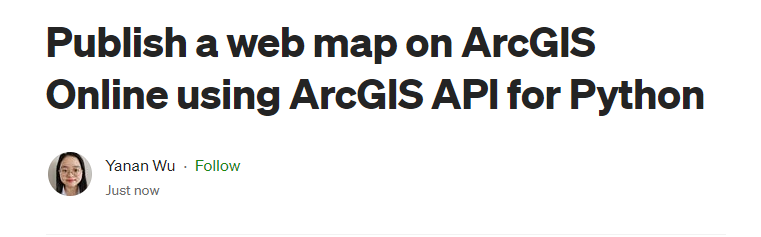

Prepare to unlock the full potential of your data visualization capabilities with ArcGIS online Dashboard!

Happy mapping!